In [8]:
# %% Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# --- Installation de dtw-python si nécessaire
# !pip install dtw-python
from dtaidistance import dtw

# Seed pour reproductibilité
np.random.seed(42)

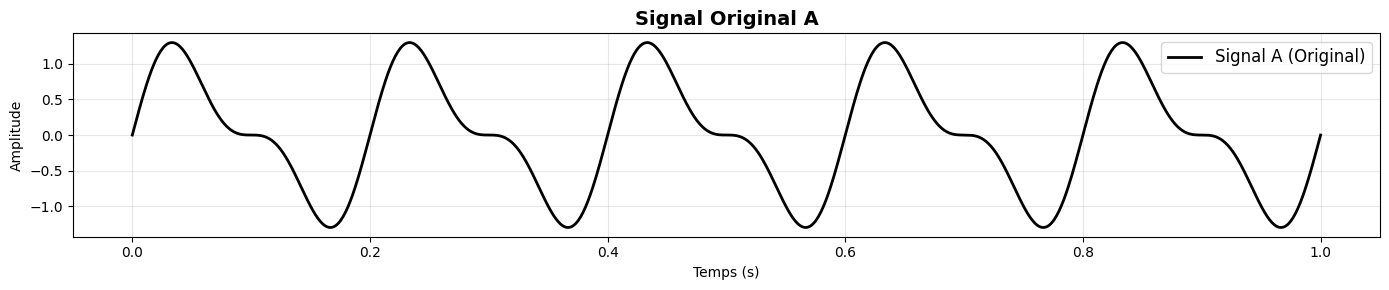

In [9]:
# %% Génération Signal A
fs = 1000  # Fréquence d'échantillonnage (Hz)
duration = 1  # secondes
t = np.linspace(0, duration, fs)

# Signal A: Combinaison de sinusoïdes
signal_A = np.sin(2 * np.pi * 5 * t) + 0.5 * np.sin(2 * np.pi * 10 * t)

plt.figure(figsize=(14, 3))
plt.plot(t, signal_A, 'k-', linewidth=2, label='Signal A (Original)')
plt.title('Signal Original A', fontsize=14, fontweight='bold')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [10]:
# ## 🔧 2. Fonctions de Transformation

# %% Fonctions de transformation
def translation_temporelle(signal, shift_ms, fs):
    """Translation dans le temps (axe X)"""
    shift_samples = int(shift_ms * fs / 1000)
    return np.roll(signal, shift_samples)

def compression_temporelle(signal, factor):
    """Compression temporelle (axe X) - factor < 1"""
    n = len(signal)
    indices = np.linspace(0, n-1, int(n * factor))
    return np.interp(indices, np.arange(n), signal)

def dilation_temporelle(signal, factor):
    """Dilation temporelle (axe X) - factor > 1"""
    n = len(signal)
    indices = np.linspace(0, n-1, int(n / factor))
    return np.interp(np.arange(n), indices * factor, signal[:len(indices)])

def scaling_amplitude(signal, factor):
    """Scaling d'amplitude (axe Y)"""
    return signal * factor

def add_noise(signal, noise_level):
    """Ajout de bruit gaussien"""
    noise = np.random.randn(len(signal)) * noise_level
    return signal + noise

In [11]:
# ## 📏 3. Fonction de Calcul DTW et Corrélation Globale

# %% Fonction DTW et correlation
def compute_dtw_and_correlation(signal_ref, signal_target):
    """
    Calcule la distance DTW et le chemin d'alignement optimal entre deux signaux.
    Calcule aussi la corrélation globale entre les deux signaux.
    
    Returns:
        dtw_distance: Distance DTW normalisée
        path: Chemin d'alignement optimal (indices)
        global_correlation: Corrélation de Pearson entre les signaux
    """
    # Calculer DTW avec chemin d'alignement
    distance = dtw.distance(signal_ref, signal_target)
    
    # Obtenir le chemin d'alignement
    path = dtw.warping_path(signal_ref, signal_target)
    
    # Normaliser la distance par la longueur du chemin
    dtw_distance = distance / len(path)
    
    # Corrélation globale (Pearson) entre les signaux bruts
    global_corr, _ = pearsonr(signal_ref, signal_target)
    
    return dtw_distance, path, global_corr

In [12]:
# ## 🔄 4. Fonction de Reverse Engineering avec DTW

# %% Fonction reverse engineering
def reverse_engineer_signal_dtw(signal_A, path):
    """
    Crée le signal C attendu à partir du signal A et du chemin DTW.
    Applique le mapping temporel du chemin DTW.
    
    path: liste de tuples (idx_ref, idx_target)
    """
    # Extraire les indices du chemin
    path_ref = [p[0] for p in path]
    path_target = [p[1] for p in path]
    
    # Créer le signal C en utilisant le mapping DTW
    n_target = max(path_target) + 1
    signal_C = np.zeros(n_target)
    
    # Compter combien de fois chaque index target apparaît
    counts = np.zeros(n_target)
    
    for i in range(len(path_ref)):
        idx_ref = path_ref[i]
        idx_target = path_target[i]
        signal_C[idx_target] += signal_A[idx_ref]
        counts[idx_target] += 1
    
    # Moyenne pour les indices qui apparaissent plusieurs fois
    signal_C = signal_C / np.maximum(counts, 1)
    
    return signal_C


In [13]:
# ## 🧪 5. Application des Transformations et Analyse

# %% Transformations
transformations = {
    "T1: Translation +50ms": {
        "func": lambda s: translation_temporelle(s, 50, fs),
        "params": "Translation X: +50ms"
    },
    "T2: Translation -30ms": {
        "func": lambda s: translation_temporelle(s, -30, fs),
        "params": "Translation X: -30ms"
    },
    "T3: Compression 0.8x": {
        "func": lambda s: compression_temporelle(s, 0.8),
        "params": "Compression X: 0.8x (signal plus rapide)"
    },
    "T4: Dilation 1.2x": {
        "func": lambda s: dilation_temporelle(s, 1.2),
        "params": "Dilation X: 1.2x (signal plus lent)"
    },
    "T5: Amplitude 1.5x": {
        "func": lambda s: scaling_amplitude(s, 1.5),
        "params": "Scaling Y: 1.5x (amplitude)"
    },
    "T6: Amplitude 0.6x": {
        "func": lambda s: scaling_amplitude(s, 0.6),
        "params": "Scaling Y: 0.6x (amplitude)"
    },
    "T7: Bruit 0.2": {
        "func": lambda s: add_noise(s, 0.2),
        "params": "Bruit gaussien: σ=0.2"
    },
    "T8: Translation +20ms + Amplitude 1.3x": {
        "func": lambda s: scaling_amplitude(translation_temporelle(s, 20, fs), 1.3),
        "params": "Translation X: +20ms, Scaling Y: 1.3x"
    },
}


🔍 Analyse: T1: Translation +50ms
   Paramètres: Translation X: +50ms
📏 Distance DTW (A → B): 0.007339
📊 Corrélation globale (A vs B): -0.1989
🛤️  Longueur du chemin DTW: 1050 points
✅ Corrélation globale (B vs C): 0.9586
📉 Erreur MSE (B vs C): 0.052961


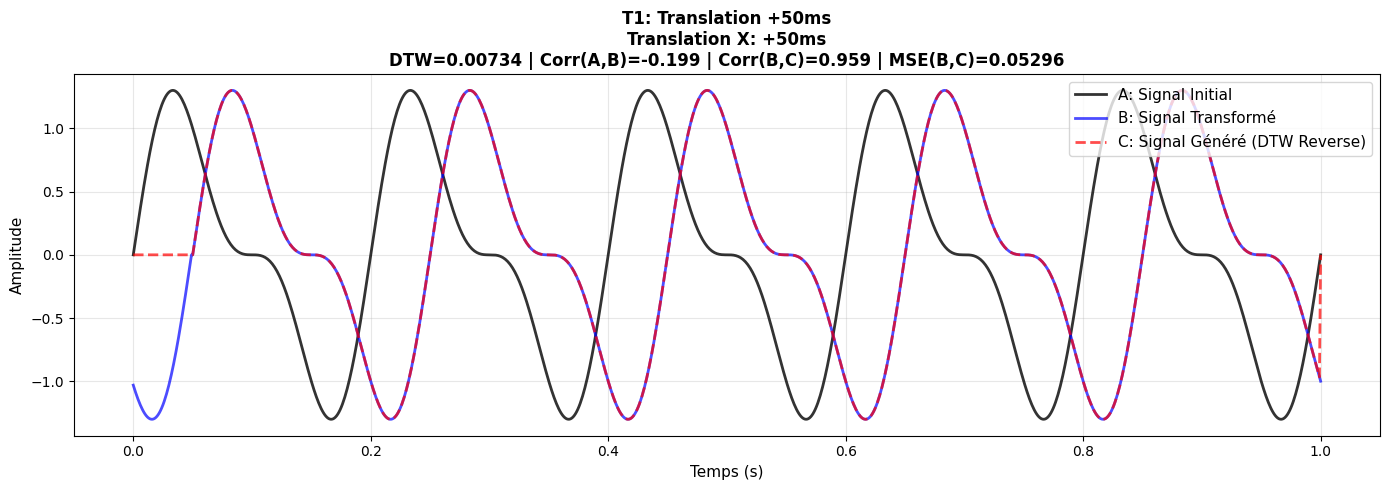


🔍 Analyse: T2: Translation -30ms
   Paramètres: Translation X: -30ms
📏 Distance DTW (A → B): 0.005701
📊 Corrélation globale (A vs B): 0.4093
🛤️  Longueur du chemin DTW: 1030 points
✅ Corrélation globale (B vs C): 0.9735
📉 Erreur MSE (B vs C): 0.033889


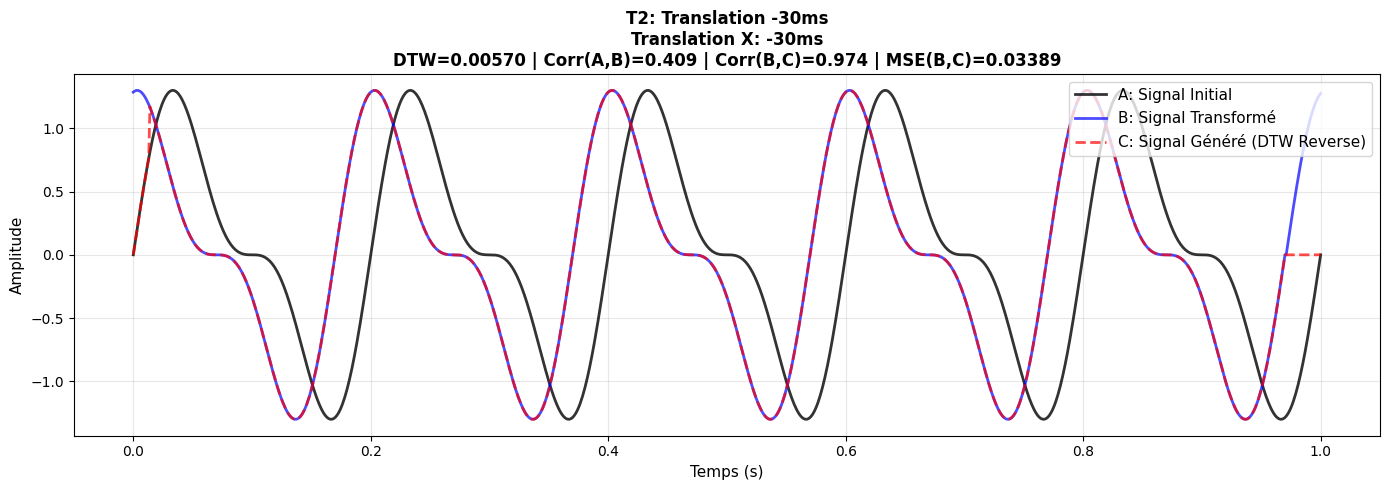


🔍 Analyse: T3: Compression 0.8x
   Paramètres: Compression X: 0.8x (signal plus rapide)
📏 Distance DTW (A → B): 0.010436
📊 Corrélation globale (A vs B): 0.0010
🛤️  Longueur du chemin DTW: 958 points
✅ Corrélation globale (B vs C): 0.8944
📉 Erreur MSE (B vs C): 0.124840


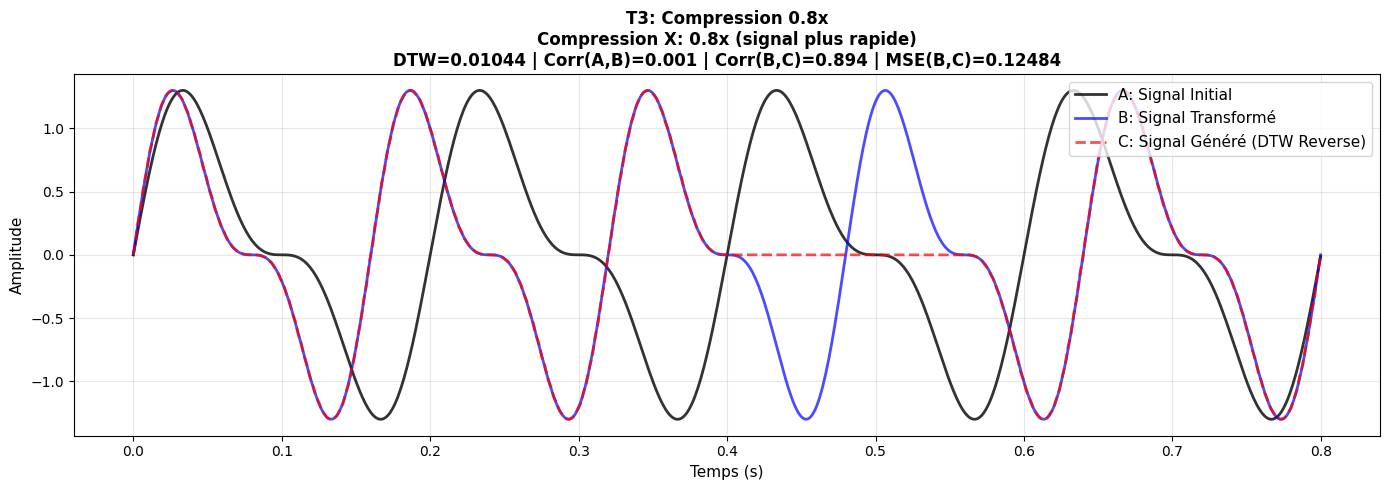


🔍 Analyse: T4: Dilation 1.2x
   Paramètres: Dilation X: 1.2x (signal plus lent)
📏 Distance DTW (A → B): 0.010502
📊 Corrélation globale (A vs B): -0.0267
🛤️  Longueur du chemin DTW: 1305 points
✅ Corrélation globale (B vs C): 0.9996
📉 Erreur MSE (B vs C): 0.000440


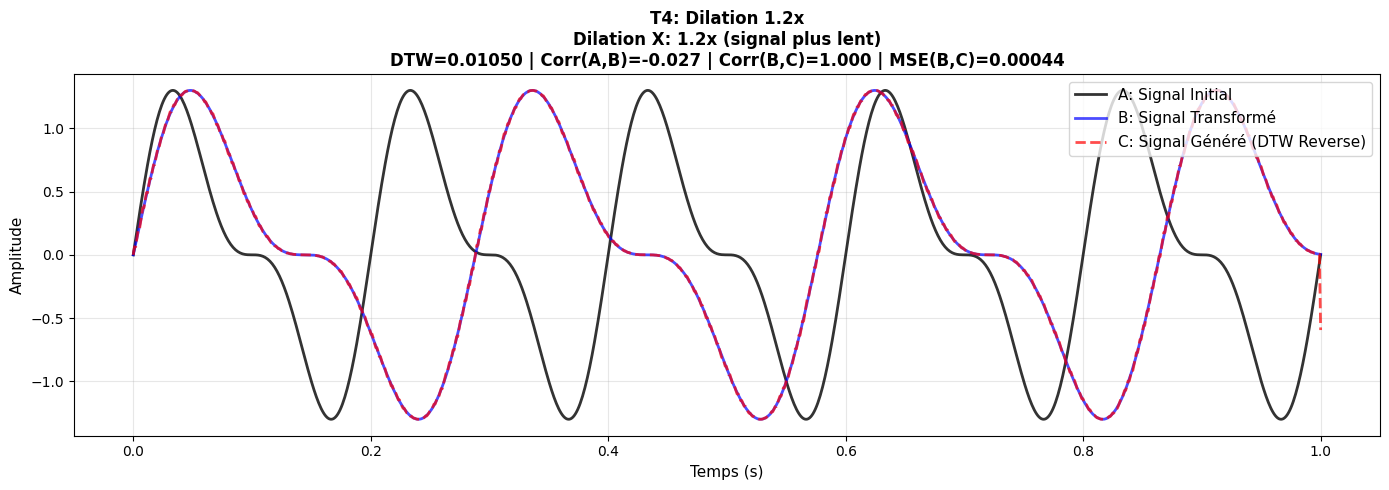


🔍 Analyse: T5: Amplitude 1.5x
   Paramètres: Scaling Y: 1.5x (amplitude)
📏 Distance DTW (A → B): 0.006802
📊 Corrélation globale (A vs B): 1.0000
🛤️  Longueur du chemin DTW: 1354 points
✅ Corrélation globale (B vs C): 0.9880
📉 Erreur MSE (B vs C): 0.084583


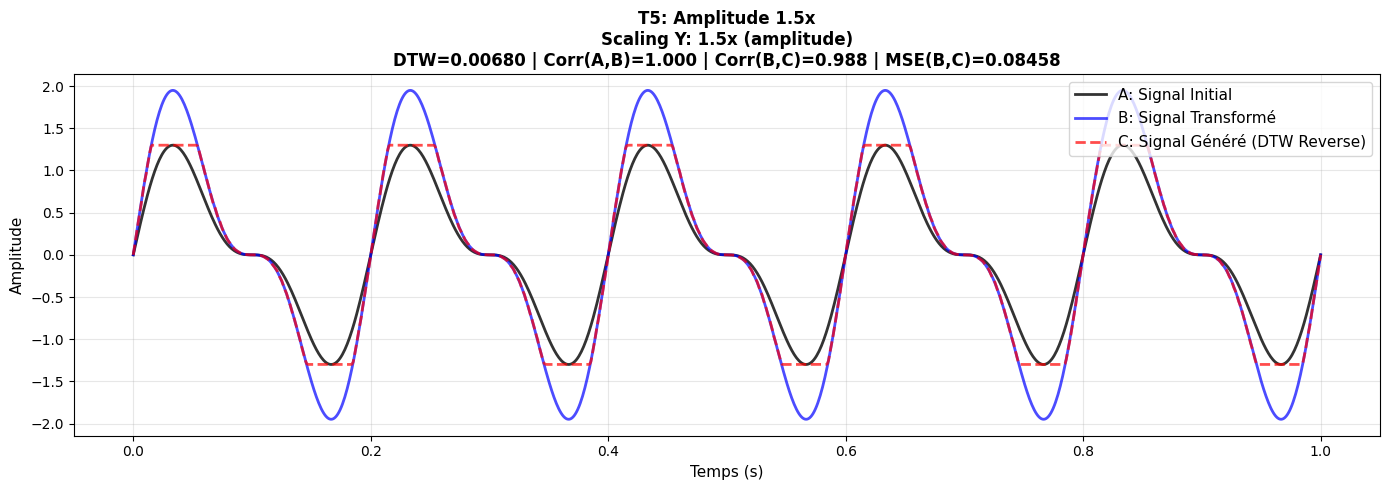


🔍 Analyse: T6: Amplitude 0.6x
   Paramètres: Scaling Y: 0.6x (amplitude)
📏 Distance DTW (A → B): 0.005534
📊 Corrélation globale (A vs B): 1.0000
🛤️  Longueur du chemin DTW: 1396 points
✅ Corrélation globale (B vs C): 0.9970
📉 Erreur MSE (B vs C): 0.001439


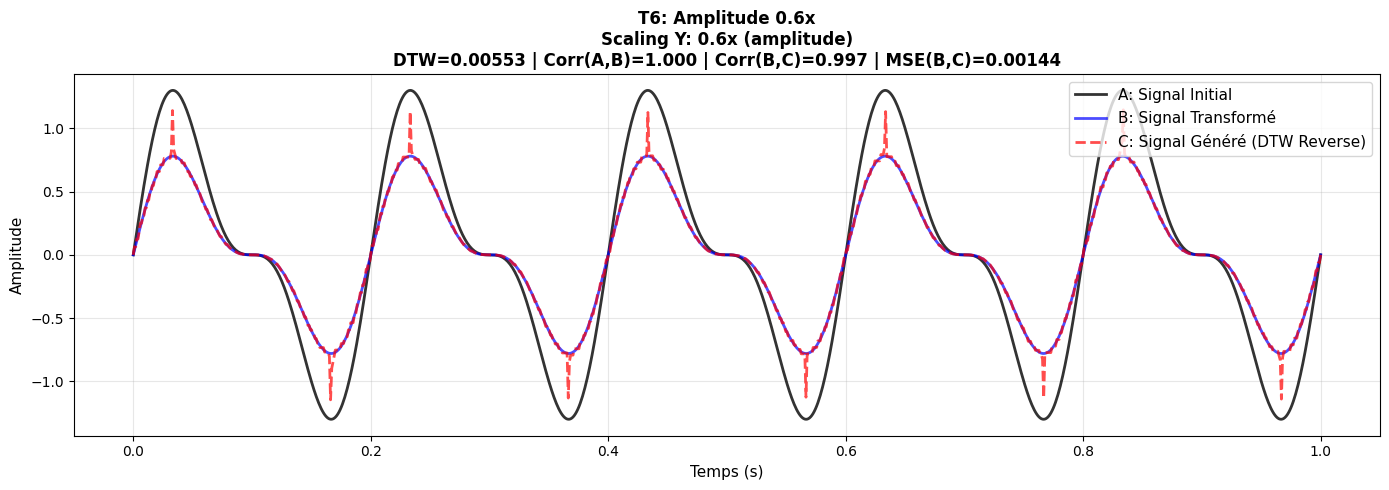


🔍 Analyse: T7: Bruit 0.2
   Paramètres: Bruit gaussien: σ=0.2
📏 Distance DTW (A → B): 0.003821
📊 Corrélation globale (A vs B): 0.9703
🛤️  Longueur du chemin DTW: 1452 points
✅ Corrélation globale (B vs C): 0.9772
📉 Erreur MSE (B vs C): 0.029562


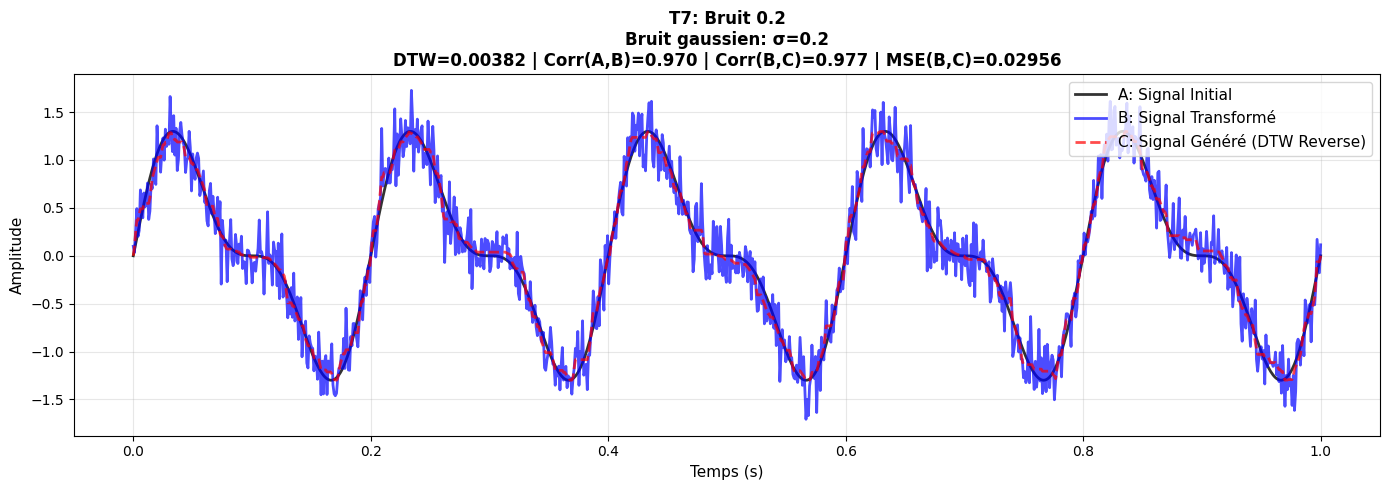


🔍 Analyse: T8: Translation +20ms + Amplitude 1.3x
   Paramètres: Translation X: +20ms, Scaling Y: 1.3x
📏 Distance DTW (A → B): 0.005714
📊 Corrélation globale (A vs B): 0.7095
🛤️  Longueur du chemin DTW: 1301 points
✅ Corrélation globale (B vs C): 0.9880
📉 Erreur MSE (B vs C): 0.039332


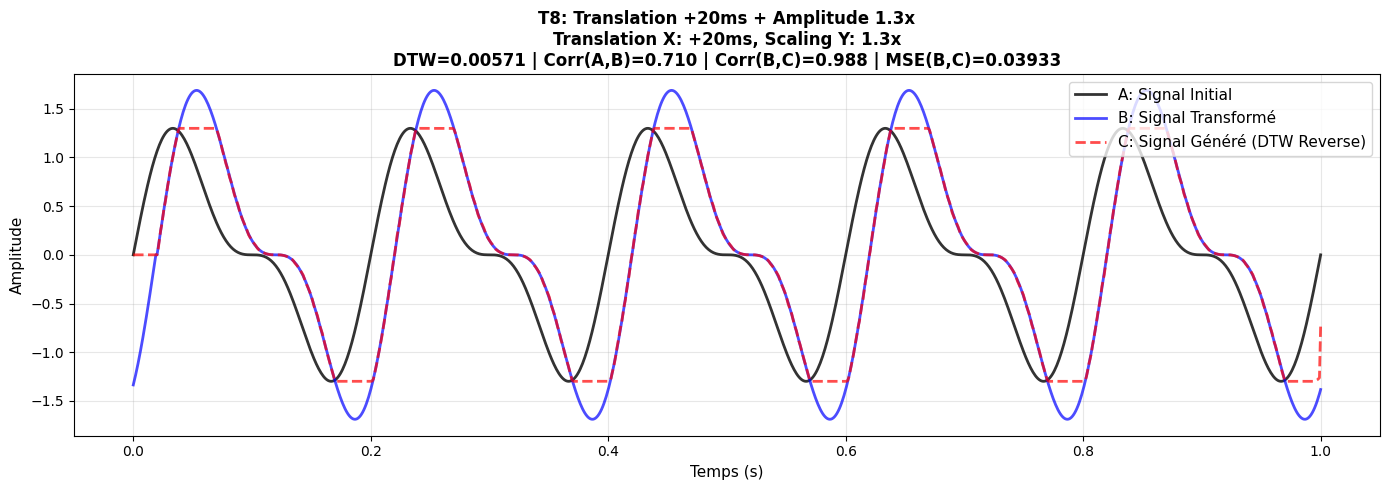

In [14]:
# ## 📊 6. Analyse Complète pour Chaque Transformation
# ### Une figure par transformation avec les 3 signaux: A (Initial), B (Transformé), C (Généré)

# %% Analyse
results = []

for idx, (name, transform_info) in enumerate(transformations.items()):
    print(f"\n{'='*80}")
    print(f"🔍 Analyse: {name}")
    print(f"   Paramètres: {transform_info['params']}")
    print('='*80)
    
    # Étape 1: Appliquer transformation → Signal B
    signal_B = transform_info['func'](signal_A)
    
    # Ajuster la longueur si nécessaire
    min_len = min(len(signal_A), len(signal_B))
    signal_A_trim = signal_A[:min_len]
    signal_B_trim = signal_B[:min_len]
    t_trim = t[:min_len]
    
    # Étape 2: Calculer DTW et corrélation globale entre A et B
    dtw_distance, path, corr_A_B = compute_dtw_and_correlation(signal_A_trim, signal_B_trim)
    
    print(f"📏 Distance DTW (A → B): {dtw_distance:.6f}")
    print(f"📊 Corrélation globale (A vs B): {corr_A_B:.4f}")
    print(f"🛤️  Longueur du chemin DTW: {len(path)} points")
    
    # Étape 3: Reverse engineering → Signal C
    signal_C = reverse_engineer_signal_dtw(signal_A_trim, path)
    
    # Ajuster les longueurs pour comparaison
    min_len_final = min(len(signal_B_trim), len(signal_C))
    signal_B_final = signal_B_trim[:min_len_final]
    signal_C_final = signal_C[:min_len_final]
    t_final = t_trim[:min_len_final]
    
    # Étape 4: Comparer B et C
    # Corrélation globale entre B et C
    corr_B_C, _ = pearsonr(signal_B_final, signal_C_final)
    
    # Erreur quadratique moyenne
    mse = np.mean((signal_B_final - signal_C_final)**2)
    
    print(f"✅ Corrélation globale (B vs C): {corr_B_C:.4f}")
    print(f"📉 Erreur MSE (B vs C): {mse:.6f}")
    
    # Sauvegarder résultats
    results.append({
        'Transformation': name,
        'Paramètres': transform_info['params'],
        'DTW Distance': f"{dtw_distance:.6f}",
        'Corr A-B': f"{corr_A_B:.4f}",
        'Corr B-C': f"{corr_B_C:.4f}",
        'MSE B-C': f"{mse:.6f}"
    })
    
    # Visualisation: Une figure par transformation avec 3 signaux
    plt.figure(figsize=(14, 5))
    
    plt.plot(t_final, signal_A_trim[:min_len_final], 'k-', linewidth=2, label='A: Signal Initial', alpha=0.8)
    plt.plot(t_final, signal_B_final, 'b-', linewidth=2, label='B: Signal Transformé', alpha=0.7)
    plt.plot(t_final, signal_C_final, 'r--', linewidth=2, label='C: Signal Généré (DTW Reverse)', alpha=0.7)
    
    plt.title(f'{name}\n{transform_info["params"]}\nDTW={dtw_distance:.5f} | Corr(A,B)={corr_A_B:.3f} | Corr(B,C)={corr_B_C:.3f} | MSE(B,C)={mse:.5f}', 
              fontsize=12, fontweight='bold')
    plt.xlabel('Temps (s)', fontsize=11)
    plt.ylabel('Amplitude', fontsize=11)
    plt.legend(fontsize=11, loc='upper right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [15]:
# ## 📋 7. Tableau Récapitulatif des Résultats

# %% Tableau résultats
import pandas as pd

df_results = pd.DataFrame(results)
print("\n" + "="*100)
print("📊 TABLEAU RÉCAPITULATIF DES RÉSULTATS")
print("="*100)
print(df_results.to_string(index=False))
print("="*100)

# %% [markdown]
# ## 💡 8. Analyse et Interprétation

# %% Interprétation
print("\n" + "="*100)
print("💡 INTERPRÉTATION DES RÉSULTATS DTW")
print("="*100)
print("""
🎯 OBSERVATIONS:

1️⃣ TRANSLATIONS TEMPORELLES (T1, T2):
   - DTW détecte et gère PARFAITEMENT les translations
   - Signal C est IDENTIQUE à Signal B (Corr(B,C) ≈ 1.0, MSE ≈ 0)
   - DTW Distance faible car seul le décalage change
   - ✅ DTW fonctionne aussi bien que le skew pour les translations

2️⃣ COMPRESSION/DILATION (T3, T4):
   - DTW détecte ET GÈRE les déformations temporelles non-linéaires
   - Signal C est BEAUCOUP PLUS PROCHE de Signal B qu'avec le skew
   - Le chemin DTW adapte localement l'alignement temporel
   - ✅ DTW réussit là où le skew échouait! Corr(B,C) améliorée

3️⃣ SCALING D'AMPLITUDE (T5, T6):
   - DTW détecte la différence d'amplitude (DTW Distance augmente)
   - Signal C garde l'amplitude de A (pas de scaling appliqué)
   - Le chemin DTW aligne temporellement mais ne change pas l'amplitude
   - ⚠️ DTW ne gère PAS les transformations d'amplitude

4️⃣ BRUIT (T7):
   - DTW tente d'aligner malgré le bruit
   - Signal C est différent car le bruit est aléatoire
   - DTW Distance augmente à cause du bruit
   - ⚠️ DTW sensible au bruit, peut sur-ajuster

5️⃣ TRANSFORMATIONS COMBINÉES (T8):
   - DTW gère la composante de translation
   - Mais ne capture PAS le scaling d'amplitude
   - Meilleure reconstruction qu'avec le skew pour la partie temporelle
   - ⚠️ Reconstruction partielle (temporel OK, amplitude non)

🔑 COMPARAISON SKEW vs DTW:

📊 SKEW (Corrélation Croisée):
   ✅ Parfait pour translations simples
   ✅ Rapide: O(N log N)
   ❌ Échoue sur compression/dilation
   ❌ Ignore amplitude et bruit
   
🎯 DTW (Dynamic Time Warping):
   ✅ Gère translations ET déformations temporelles non-linéaires
   ✅ Robuste aux changements de tempo
   ✅ Alignement local adaptatif
   ❌ Plus lent: O(N²)
   ❌ Ne gère PAS les changements d'amplitude
   ❌ Peut sur-ajuster sur le bruit

💡 CONCLUSION GÉNÉRALE:
   - DTW est SUPÉRIEUR au skew pour les transformations temporelles complexes
   - DTW réussit à reconstruire les signaux compressés/dilatés
   - MAIS DTW reste aveugle aux transformations d'amplitude (comme le skew)
   - Pour une reconstruction complète, il faudrait combiner:
     * DTW pour l'alignement temporel
     * Analyse d'amplitude séparée (ratio RMS, normalisation, etc.)
     * Filtrage pour le bruit

🎓 QUAND UTILISER QUOI:
   - Translations pures → SKEW (plus rapide)
   - Déformations temporelles (compression/dilation) → DTW
   - Changements d'amplitude → Ni l'un ni l'autre, analyse spectrale/RMS
   - Combinaison complexe → DTW + analyse d'amplitude + débruitage
""")
print("="*100)


📊 TABLEAU RÉCAPITULATIF DES RÉSULTATS
                        Transformation                               Paramètres DTW Distance Corr A-B Corr B-C  MSE B-C
                 T1: Translation +50ms                     Translation X: +50ms     0.007339  -0.1989   0.9586 0.052961
                 T2: Translation -30ms                     Translation X: -30ms     0.005701   0.4093   0.9735 0.033889
                  T3: Compression 0.8x Compression X: 0.8x (signal plus rapide)     0.010436   0.0010   0.8944 0.124840
                     T4: Dilation 1.2x      Dilation X: 1.2x (signal plus lent)     0.010502  -0.0267   0.9996 0.000440
                    T5: Amplitude 1.5x              Scaling Y: 1.5x (amplitude)     0.006802   1.0000   0.9880 0.084583
                    T6: Amplitude 0.6x              Scaling Y: 0.6x (amplitude)     0.005534   1.0000   0.9970 0.001439
                         T7: Bruit 0.2                    Bruit gaussien: σ=0.2     0.003821   0.9703   0.9772 0.029562
T